# 获取黄金的指标

In [10]:
import pandas as pd 

In [11]:
data_gold = pd.read_csv("gold_data.csv",encoding='GBK')
data_gold.head(3)

,Date,Close,Open,High,Low,Vol,Per,Dollars
0,1979/12/27,515.5,517.00,517.0,513.00,-,1.82%,NaN
1,1979/12/28,517.8,516.00,517.8,510.40,-,0.45%,NaN
2,1979/12/31,533.6,527.88,534.5,527.88,-,3.05%,NaN


In [57]:
def get_technical_indicators(dataset):
    # Create 7 and 21 Moving Average 这里使用open price 是为了防止信息泄露
    dataset['ma7'] = dataset['Open'].rolling(window = 8).mean()
    dataset['ma21'] = dataset['Open'].rolling(window = 21).mean()
    
    #Create MACD
    
    dataset['26ema'] = pd.DataFrame.ewm(dataset['Open'] ,span =26).mean()
    dataset['12ema'] = pd.DataFrame.ewm(dataset['Open'] ,span =12).mean()
    dataset['MACD'] =(dataset['12ema']- dataset['26ema'])
    
    #Greate Bollinger Bands
    dataset['20sd'] = dataset['Open'].rolling(window =20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    return dataset[21:]

data_gold_TI  = get_technical_indicators(data_gold)
data_gold_TI.head(6)
len(data_gold_TI)

10345

In [13]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['High'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    

    plt.legend()
    plt.show()

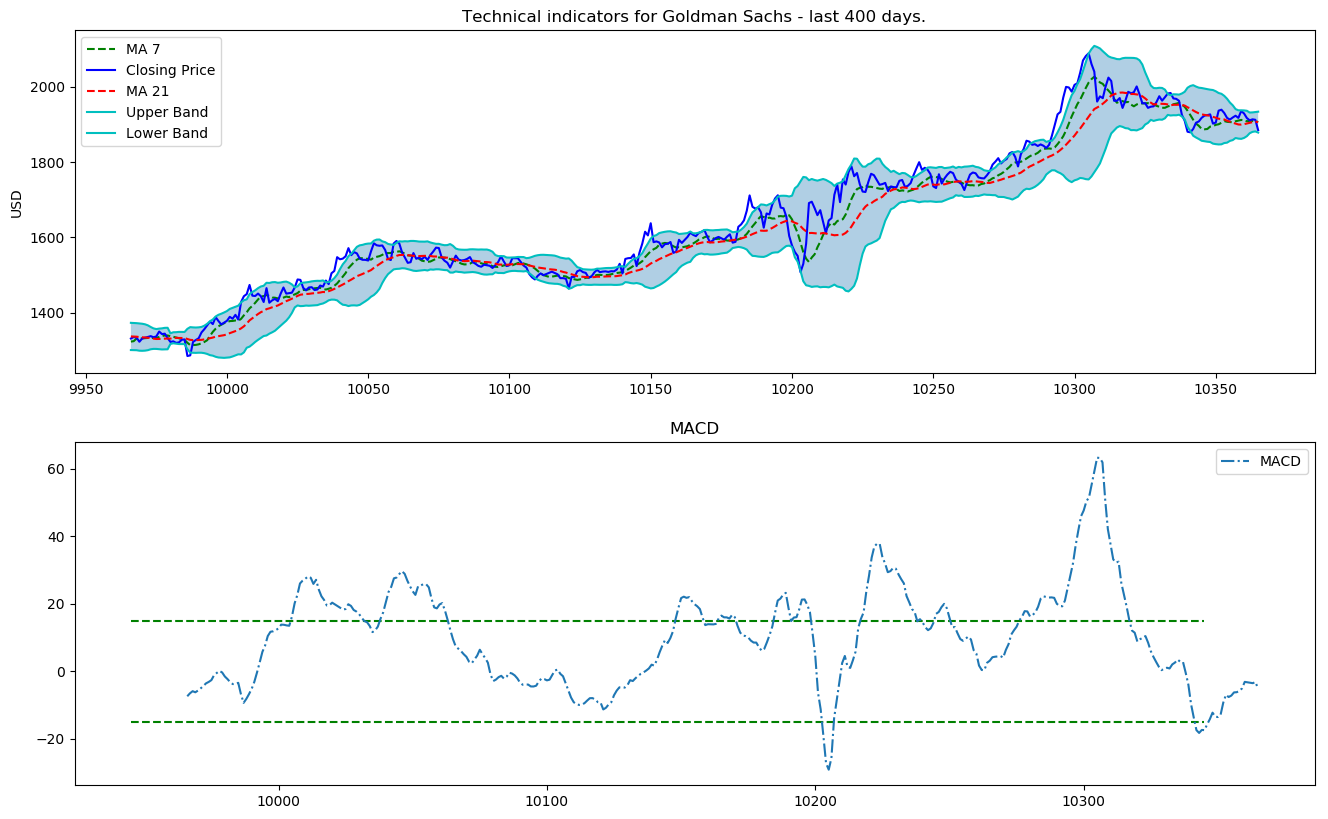

In [14]:
import matplotlib.pyplot as plt
plot_technical_indicators(data_gold_TI,400)

In [15]:
import xgboost as xgb 


In [122]:
def get_feature_importance_data(data):
    y = data['Close'] 
    X = data.drop(['Date','High','Low','Vol','Per','Close','Open'], axis =1)
    train_samples = int(X.shape[0] * 0.7)
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]
    
    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    return (X_train,y_train), (X_test,y_test)

In [123]:
data = data_gold_TI[7600:].copy()

In [132]:
#Get training and test data 
(X_train,y_train), (X_test,y_test) = get_feature_importance_data(data)
X_train = X_train.astype('float').apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
#y_train.astype('float').apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
y_train = (y_train - y_train.min()) / (y_train.max() - y_train.min())

In [133]:
type(X_train['Dollars'])
#len(y_train)
y_train.head(4)

7621    0.078738
7622    0.082895
7623    0.094633
7624    0.087419
Name: Close, dtype: float64

In [145]:
regressor = xgb.XGBRegressor(gamma=0.0, n_estimators=150, base_score=0.7, colsample_bytree =1, learning_rate=0.05)

In [146]:
xgb_model = regressor.fit(X_train,y_train, eval_set=[(X_train,y_train), (X_test,y_test)], verbose=False)

In [147]:
eval_result = regressor.evals_result()

In [148]:
regressor = xgb.XGBRegressor(gamma=0.0, n_estimators=150, base_score=0.7, colsample_bytree =1, learning_rate=0.05)

xgb_model = regressor.fit(X_train,y_train, eval_set=[(X_train,y_train), (X_test,y_test)], verbose=False)

eval_result = regressor.evals_result()

In [138]:
import matplotlib.pyplot as plt
%matplotlib inline

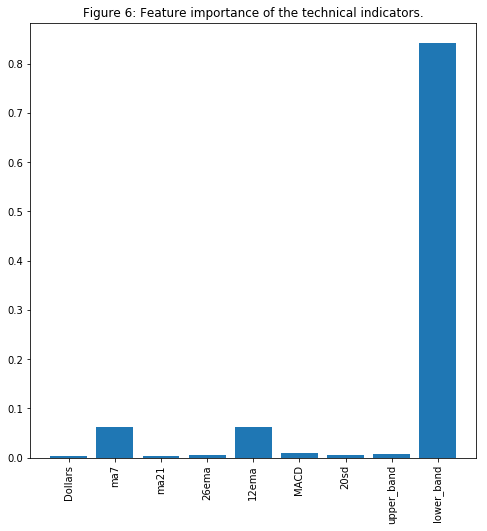

In [139]:

fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgb_model.feature_importances_))], xgb_model.feature_importances_.tolist(), tick_label=X_test.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

### 以上是归一化的特征影响力， ma7 12ema lower_band 是最大的

### 下面不进行归一化训练

In [140]:
(X_train,y_train), (X_test,y_test) = get_feature_importance_data(data)

In [141]:
regressor = xgb.XGBRegressor(gamma=0.0, n_estimators=150, base_score=0.7, colsample_bytree =1, learning_rate=0.05)

xgb_model = regressor.fit(X_train,y_train, eval_set=[(X_train,y_train), (X_test,y_test)], verbose=False)

eval_result = regressor.evals_result()

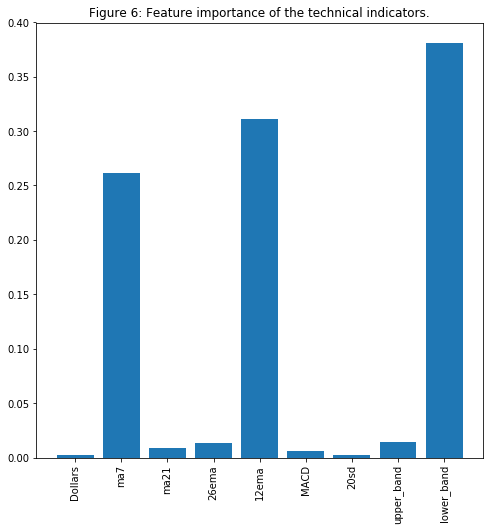

In [142]:
import matplotlib.pyplot as plt
%matplotlib inline


fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgb_model.feature_importances_))], xgb_model.feature_importances_.tolist(), tick_label=X_test.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

#### 依然是ma7 ma21 lower_band 影响力最大

### 下面加入当天开盘价作为feature

In [153]:
def get_feature_importance_data_having_open(data):
    y = data['Close'] 
    X = data.drop(['Date','High','Low','Vol','Per','Close',], axis =1)
    train_samples = int(X.shape[0] * 0.7)
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]
    
    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    return (X_train,y_train), (X_test,y_test)

In [154]:
data = data_gold_TI[7600:].copy()

#Get training and test data 
(X_train,y_train), (X_test,y_test) = get_feature_importance_data_having_open(data)
X_train = X_train.astype('float').apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
#y_train.astype('float').apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
y_train = (y_train - y_train.min()) / (y_train.max() - y_train.min())

In [156]:
regressor = xgb.XGBRegressor(gamma=0.0, n_estimators=150, base_score=0.7, colsample_bytree =1, learning_rate=0.05)

xgb_model = regressor.fit(X_train,y_train, eval_set=[(X_train,y_train), (X_test,y_test)], verbose=False)

eval_result = regressor.evals_result()

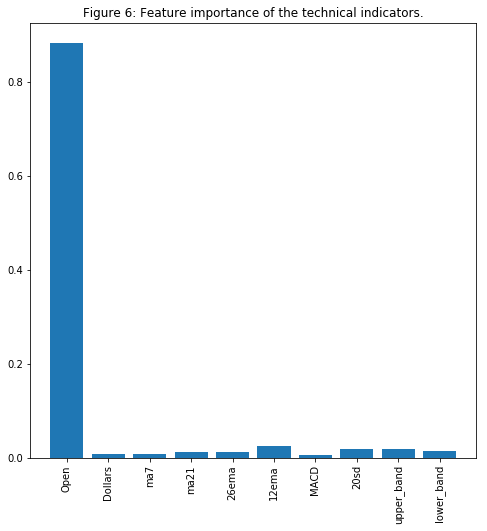

In [157]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgb_model.feature_importances_))], xgb_model.feature_importances_.tolist(), tick_label=X_test.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

#### 这里看出open price 对 close price 的影响力最大，这也是符合常理的，也在一定程度上说明了xgb模型的有效性